In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from lava.lib.dl.slayer.state_space_models.s4 import S4D
import os
import matplotlib.pyplot as plt
import h5py

import torch
import torch.nn.functional as F

import lava.lib.dl.slayer as slayer
import torch

# Dropout broke in PyTorch 1.11
if tuple(map(int, torch.__version__.split('.')[:2])) == (1, 11):
    print("WARNING: Dropout is bugged in PyTorch 1.11. Results may be worse.")
    dropout_fn = nn.Dropout
if tuple(map(int, torch.__version__.split('.')[:2])) >= (1, 12):
    dropout_fn = nn.Dropout1d
else:
    dropout_fn = nn.Dropout2d

random_seed = 4#3
import torch
torch.manual_seed(random_seed)
import random
random.seed(random_seed)
import numpy as np
np.random.seed(random_seed)

CUDA extension for structured kernels (Cauchy and Vandermonde multiplication) not found. Install by going to extensions/kernels/ and running `python setup.py install`, for improved speed and memory efficiency. Note that the kernel changed for state-spaces 4.0 and must be recompiled.
Falling back on slow Cauchy and Vandermonde kernel. Install at least one of pykeops or the CUDA extension for better speed and memory efficiency.


In [2]:
batch_size = 1 
inp_dim = 4
actual_inp = inp_dim
L = 10 # sequence length
dropout = 0
inp = torch.rand(batch_size, actual_inp, L)
d_state = 1

In [3]:
model = S4D(d_model=inp_dim,
            d_state=d_state,
            dropout=dropout,
            transposed=True,
            final_act = None,
            activation = None,
            skip=False,
            lr=None,
            is_real=True)
model.__name__ = "S4D"
model.setup_step()


identity = nn.Identity()
identity.__name__ = "identity"

class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        
        sdnn_params = { # sigma-delta neuron parameters
                'threshold'     : 0,    # delta unit threshold
                'tau_grad'      : 0.5,    # delta unit surrogate gradient relaxation parameter
                'scale_grad'    : 1,      # delta unit surrogate gradient scale parameter
                'requires_grad' : False,   # trainable threshold
                'shared_param'  : True,   # layer wise threshold
               # 'activation'    : model, # activation function
            ## 'activation' : F.relu

            }
        sdnn_S4d_params = { # conv layer has additional mean only batch norm
                **sdnn_params,                                 # copy all sdnn_params
                'activation' : model, # mean only quantized batch normalizaton
            }
        sdnn_dense_params = { # dense layers have additional dropout units enabled
                **sdnn_params,                        # copy all sdnn_cnn_params
                # 'activation' : identity 
                'activation' : F.relu
            }

        standard_params ={**sdnn_params, "activation" : identity} 

        input_params ={**sdnn_params, "activation": identity}
        
        self.blocks = torch.nn.ModuleList([# sequential network blocks
                slayer.block.sigma_delta.Input(input_params), 
                # slayer.block.sigma_delta.Dense(standard_params, 3, inp_dim),

                slayer.block.sigma_delta.Dense(sdnn_S4d_params, inp_dim, inp_dim),
                slayer.block.sigma_delta.Dense(sdnn_dense_params, inp_dim, inp_dim),
        ])

        self.blocks[1].synapse.weight.data = torch.eye(inp_dim).reshape((inp_dim,inp_dim,1,1,1))
        self.blocks[1].synapse.weight.requires_grad = False
               
        self.blocks[2].synapse.weight.data = torch.eye(inp_dim).reshape((inp_dim,inp_dim,1,1,1))
        self.blocks[2].synapse.weight.requires_grad = False

 
  
    def forward(self, x):        
        for block in self.blocks: 
            # forward computation is as simple as calling the blocks in a loop
            x = block(x)
        return x
    
    def export_hdf5(self, filename):
        # network export to hdf5 format
        h = h5py.File(filename, 'w')
        layer = h.create_group('layer')
        for i, b in enumerate(self.blocks):
            b.export_hdf5(layer.create_group(f'{i}'))
        

In [4]:
# Generate output in different ways
import numpy as np

np_inp = inp.numpy()
diff_inp = np.diff(np.insert(np_inp, 0, 0, axis=2))


diff_inp = inp[:,:, 1:] - inp[:, :, :-1]
diff_inp = torch.concatenate((inp[:, :, :1], diff_inp), axis=2) 


#diff_inp = torch.from_numpy(diff_inp)
# Lava-dl output
net = Network()
out_dl = net(inp)

# Original Network
#out_original = model(inp)

# Step output
#out_step = torch.zeros_like(out_dl)
#state = model.default_state(batch_size)
#for t in range(L):
    #y, state = model.step(inp[:, :, t], state)
    #out_step[0, :, t] = y

In [5]:
from lava.lib.dl import netx
net.export_hdf5("debug.net")
loaded_net =  netx.hdf5.Network(net_config='debug.net', input_message_bits=24, sparse_fc_layer=True, skip_layers=1)
os.remove("debug.net")
print(loaded_net)

|   Type   |  W  |  H  |  C  | ker | str | pad | dil | grp |delay|
|Dense     |    1|    1|    4|     |     |     |     |     |False|
|Dense     |    1|    1|    4|     |     |     |     |     |False|


In [6]:
inp_exp = 6
lava_inp = diff_inp.detach().numpy().reshape((actual_inp, L)) * 2**inp_exp


In [7]:
# get output from loaded lava net
from lava.proc.io.source import RingBuffer as SourceBuffer
from lava.proc.io.sink import RingBuffer as SinkBuffer
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi2HwCfg
from lava.proc.s4d.ncmodels import NcModelSigmaS4dDelta
from lava.proc.s4d.process import SigmaS4dDelta
from lava.proc.embedded_io.spike import PyToNxAdapter, NxToPyAdapter

# Enable SLURM, the workload manager used to distribute Loihi2 resources to users
os.environ['SLURM'] = '1'
os.environ['PARTITION'] = "oheogulch"
os.environ['LOIHI_GEN'] = "N3C1"

n_steps = L

spiker = SourceBuffer(data=lava_inp)
adapter_i = PyToNxAdapter(shape=(actual_inp, ), num_message_bits=24)
adapter_o = NxToPyAdapter(shape=(inp_dim,), num_message_bits=24)
receiver = SinkBuffer(buffer = n_steps+len(loaded_net), shape=(inp_dim,))


spiker.s_out.connect(adapter_i.inp)
adapter_i.out.connect(loaded_net.inp)
loaded_net.out.connect(adapter_o.inp)
adapter_o.out.connect(receiver.a_in)

run_cfg = Loihi2HwCfg()

In [8]:
run_cfg = Loihi2HwCfg()
 
run_cond = RunSteps(num_steps=1)
sigmas = np.zeros((inp_dim, L+len(loaded_net)))
act_refs = np.zeros((inp_dim, L+len(loaded_net)))

sigmas_s4d = np.zeros((inp_dim, L+len(loaded_net)))
act_refs_s4d = np.zeros((inp_dim, L+len(loaded_net)))

for t in range(L+len(loaded_net)):

    loaded_net.run(run_cond, run_cfg)
    sigmas[:, t] = loaded_net.layers[-1].neuron.sigma.get()
    act_refs[:, t] = loaded_net.layers[-1].neuron.act.get()
    sigmas_s4d[:, t] = loaded_net.layers[-2].neuron.sigma.get()
    act_refs_s4d[:, t] = loaded_net.layers[-2].neuron.act.get()

received_data_lava = receiver.data.get()
# loaded_net.stop()


NC PROC 0


/home/pweidel/lava-nc/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


In [9]:
loaded_net.stop()

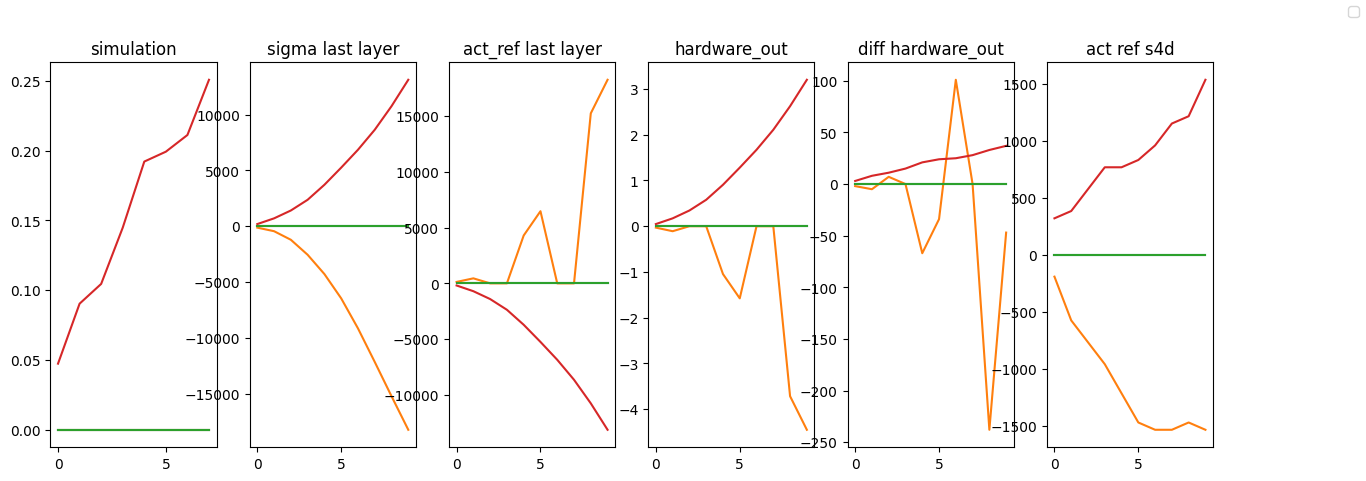

In [10]:
fig, axs = plt.subplots(1, 6, figsize=(15, 5))
axs[0].plot(np.cumsum(out_dl[0].detach().numpy(), axis=1)[:, :-len(loaded_net)].T);
axs[0].set_title("simulation")

axs[1].plot(sigmas[:, len(loaded_net):].T.astype(np.int16))
axs[1].set_title("sigma last layer")
axs[2].plot(act_refs[:, len(loaded_net):].T.astype(np.int16))
axs[2].set_title("act_ref last layer")
axs[3].plot(np.cumsum(received_data_lava, axis=1)[:, len(loaded_net):].T.astype(np.int16) / 2**inp_exp);
axs[3].set_title("hardware_out")
axs[4].plot(received_data_lava[:, len(loaded_net):].T.astype(np.int16));
axs[4].set_title("diff hardware_out")
axs[5].plot(act_refs_s4d[:, len(loaded_net):].T.astype(np.int16));
axs[5].set_title("act ref s4d")
fig.legend()

#error = np.cumsum(out_dl[0].detach().numpy(), axis=1)[:, :-2].T - np.cumsum(received_data_lava, axis=1)[:, 2:].T.astype(np.int16)* 2**-inp_exp
#summed_error = np.sum(error**2)
#print(f"{summed_error=}")

In [11]:
received_data_lava[1]#.astype(np.int32)

array([0.0000e+00, 0.0000e+00, 6.5534e+04, 6.5531e+04, 7.0000e+00,
       0.0000e+00, 6.5469e+04, 6.5502e+04, 1.0100e+02, 0.0000e+00,
       6.5298e+04, 6.5489e+04])

In [12]:
act_refs[1].astype(np.int16)

array([    0,     0,   128,   448,     0,     0,  4288,  6464,     0,
           0, 15232, 18240], dtype=int16)

In [13]:
act_refs[1][2]#.astype(np.int16)

-4194176.0

In [14]:
inp = sigmas_s4d[1].astype(np.int32)
print(inp)
s4d_out = act_refs_s4d[1]
print(s4d_out)

[   0 1280  896 3776 1984 2432 3200 3072  832 1152   64 1344]
[    0.  -128.  -192.  -576.  -768.  -960. -1216. -1472. -1536. -1536.
 -1472. -1536.]


In [15]:
a = loaded_net.layers[0].neuron.a.init[1]
b = loaded_net.layers[0].neuron.b.init[1]
c = loaded_net.layers[0].neuron.c.init[1]
print(a, b, c)

3909 -264 3282


In [32]:
act_refs_s4d[1].astype(np.uint32)

array([         0, 4294967168, 4294967104, 4294966720, 4294966528,
       4294966336, 4294966080, 4294965824, 4294965760, 4294965760,
       4294965824, 4294965760], dtype=uint32)

In [42]:
2**24 - 128

16777088

In [16]:
s4state = 0
sigmas_s4d[1][1]


1280.0

In [17]:
s4state = (s4state * a) >> 12
s4state += (1280 * b) >> 12
print(s4state)

-83


In [18]:
out = (s4state * c) >> 12
out *= 2
print(out, (out >> 6) +1 , ((out >> 6) +1) << 6)

-134 -2 -128


In [47]:
sigmas[1].astype(np.int16)

array([     0,      0,   -128,   -448,  -1216,  -2560,  -4288,  -6464,
        -9152, -12160, -15232, -18240], dtype=int16)

In [46]:
2**22 - 4194176

4194176

In [20]:
act_refs[1].astype(np.int16)

array([    0,     0,   128,   448,     0,     0,  4288,  6464,     0,
           0, 15232, 18240], dtype=int16)

In [21]:
-192 

-192

In [22]:
2**22 - 128

4194176

In [23]:
-130 * 64

-8320

In [24]:
model_dim = 3
d_states = 5
dense_weight = np.random.randint(0, high=100, size=(model_dim, model_dim))

standard_kron = np.kron(np.eye(model_dim), np.ones(d_states))

# Expansion
inp = np.asarray([1,2,3])
# first through dense
out1 = np.dot(dense_weight, inp)
out2 = np.dot(standard_kron.T, out1)

one_matrix = np.dot(standard_kron.T, dense_weight)
out3 = np.dot(one_matrix, inp)

dense_kron = np.kron(dense_weight.T, np.ones(d_states))

In [25]:
# Reduction 
inp = np.asarray([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
out1 = np.dot(standard_kron, inp)
out2 = np.dot(dense_weight, out1)

one_matrix = np.dot(dense_weight, standard_kron)
out3 = np.dot(one_matrix, inp)

In [26]:
dense_weight = np.random.randint(0, high=100, size=(model_dim, model_dim))
dense_kron = np.kron(dense_weight, np.ones(d_states))
standard_kron = np.kron(np.eye(model_dim), np.ones(d_states))